In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Check for GPU
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
print("Running on ", device)

# Load the data
FirstData = np.load("cat4gaia.npy", allow_pickle=True)

# Split the data into features and labels
X = FirstData[:, 1:-1]  # All columns except the last one and first one
y = FirstData[:, -1]    # The last column
ypreencode = y

# Use LabelEncoder instead of OneHotEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y.reshape(-1, 1))

# Convert y to a PyTorch tensor and move to the GPU (if available)
y = torch.tensor(y, dtype=torch.long).to(device)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.cpu().numpy(), test_size=0.25, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

# Create PyTorch Datasets and DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, 60)
        self.fc3 = nn.Linear(60, 60)
        self.fc4 = nn.Linear(60, 60)
        self.fc5 = nn.Linear(60, output_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Calculate class weights
class_counts = np.bincount(y_train_tensor.cpu().numpy())
total_samples = sum(class_counts)
class_weights = [total_samples / count for count in class_counts]
class_weights = torch.tensor(np.clip(class_weights, 0, 100), dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
output_size = len(np.unique(ypreencode))
model = NeuralNetwork(input_size, output_size).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.003)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, verbose=True)

# Early stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Function to calculate accuracy
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    return correct / total

# Training the model with a loading bar, early stopping, and adaptive learning rate
epochs = 200
early_stopping = EarlyStopping(patience=10, min_delta=0.001)
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{epochs}', unit='batch') as pbar:
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            pbar.set_postfix({'Loss': f'{running_loss/len(train_loader):.4f}'})
            pbar.update(1)

    # Validate the model
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(test_loader)
    scheduler.step(val_loss)  # Step the scheduler
    print(f'\nValidation Loss after Epoch {epoch+1}: {val_loss:.4f}')

    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    # Calculate and print the test accuracy after each epoch
    test_accuracy = calculate_accuracy(test_loader, model)
    print(f'Test Accuracy after Epoch {epoch+1}: {test_accuracy:.4f}')


Running on  cpu


C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jcwin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/200: 100%|██████████| 10775/10775 [00:28<00:00, 383.23batch/s, Loss=0.4912]



Validation Loss after Epoch 1: 0.4407
Test Accuracy after Epoch 1: 0.8763


Epoch 2/200: 100%|██████████| 10775/10775 [00:29<00:00, 367.17batch/s, Loss=0.4195]



Validation Loss after Epoch 2: 0.5163
Test Accuracy after Epoch 2: 0.9234


Epoch 3/200: 100%|██████████| 10775/10775 [00:30<00:00, 349.03batch/s, Loss=0.4099]



Validation Loss after Epoch 3: 0.4233
Test Accuracy after Epoch 3: 0.8940


Epoch 4/200: 100%|██████████| 10775/10775 [00:30<00:00, 350.46batch/s, Loss=0.4113]



Validation Loss after Epoch 4: 0.3700
Test Accuracy after Epoch 4: 0.9145


Epoch 5/200: 100%|██████████| 10775/10775 [00:28<00:00, 384.81batch/s, Loss=0.3971]



Validation Loss after Epoch 5: 0.3866
Test Accuracy after Epoch 5: 0.9159


Epoch 6/200: 100%|██████████| 10775/10775 [00:28<00:00, 372.10batch/s, Loss=0.3967]



Validation Loss after Epoch 6: 0.4041
Test Accuracy after Epoch 6: 0.9227


Epoch 7/200: 100%|██████████| 10775/10775 [00:28<00:00, 380.61batch/s, Loss=0.3916]



Validation Loss after Epoch 7: 0.3862
Test Accuracy after Epoch 7: 0.9055


Epoch 8/200: 100%|██████████| 10775/10775 [00:29<00:00, 370.36batch/s, Loss=0.3919]



Validation Loss after Epoch 8: 0.4394
Test Accuracy after Epoch 8: 0.9321


Epoch 9/200: 100%|██████████| 10775/10775 [00:29<00:00, 369.32batch/s, Loss=0.3231]



Validation Loss after Epoch 9: 0.3333
Test Accuracy after Epoch 9: 0.9285


Epoch 10/200: 100%|██████████| 10775/10775 [00:29<00:00, 367.60batch/s, Loss=0.3132]



Validation Loss after Epoch 10: 0.3231
Test Accuracy after Epoch 10: 0.9358


Epoch 11/200: 100%|██████████| 10775/10775 [00:29<00:00, 363.05batch/s, Loss=0.3090]



Validation Loss after Epoch 11: 0.3626
Test Accuracy after Epoch 11: 0.9396


Epoch 12/200: 100%|██████████| 10775/10775 [00:31<00:00, 346.59batch/s, Loss=0.3098]



Validation Loss after Epoch 12: 0.3109
Test Accuracy after Epoch 12: 0.9289


Epoch 13/200: 100%|██████████| 10775/10775 [00:33<00:00, 325.03batch/s, Loss=0.3000]



Validation Loss after Epoch 13: 0.3236
Test Accuracy after Epoch 13: 0.9436


Epoch 14/200: 100%|██████████| 10775/10775 [00:36<00:00, 296.65batch/s, Loss=0.2998]



Validation Loss after Epoch 14: 0.3236
Test Accuracy after Epoch 14: 0.9258


Epoch 15/200: 100%|██████████| 10775/10775 [00:36<00:00, 294.65batch/s, Loss=0.2940]



Validation Loss after Epoch 15: 0.3138
Test Accuracy after Epoch 15: 0.9354


Epoch 16/200: 100%|██████████| 10775/10775 [00:34<00:00, 308.43batch/s, Loss=0.2967]



Validation Loss after Epoch 16: 0.3088
Test Accuracy after Epoch 16: 0.9268


Epoch 17/200: 100%|██████████| 10775/10775 [00:34<00:00, 312.06batch/s, Loss=0.2935]



Validation Loss after Epoch 17: 0.3230
Test Accuracy after Epoch 17: 0.9206


Epoch 18/200: 100%|██████████| 10775/10775 [00:34<00:00, 309.15batch/s, Loss=0.2926]



Validation Loss after Epoch 18: 0.3158
Test Accuracy after Epoch 18: 0.9352


Epoch 19/200: 100%|██████████| 10775/10775 [00:37<00:00, 287.31batch/s, Loss=0.2963]



Validation Loss after Epoch 19: 0.3143
Test Accuracy after Epoch 19: 0.9254


Epoch 20/200: 100%|██████████| 10775/10775 [00:33<00:00, 322.15batch/s, Loss=0.2943]



Validation Loss after Epoch 20: 0.3195
Test Accuracy after Epoch 20: 0.9292


Epoch 21/200: 100%|██████████| 10775/10775 [00:32<00:00, 334.40batch/s, Loss=0.2753]



Validation Loss after Epoch 21: 0.3017
Test Accuracy after Epoch 21: 0.9260


Epoch 22/200: 100%|██████████| 10775/10775 [00:31<00:00, 338.31batch/s, Loss=0.2702]



Validation Loss after Epoch 22: 0.2973
Test Accuracy after Epoch 22: 0.9360


Epoch 23/200: 100%|██████████| 10775/10775 [00:32<00:00, 335.51batch/s, Loss=0.2640]



Validation Loss after Epoch 23: 0.2973
Test Accuracy after Epoch 23: 0.9317


Epoch 24/200: 100%|██████████| 10775/10775 [00:37<00:00, 289.83batch/s, Loss=0.2668]



Validation Loss after Epoch 24: 0.2953
Test Accuracy after Epoch 24: 0.9328


Epoch 25/200: 100%|██████████| 10775/10775 [00:47<00:00, 228.17batch/s, Loss=0.2620]



Validation Loss after Epoch 25: 0.2985
Test Accuracy after Epoch 25: 0.9289


Epoch 26/200: 100%|██████████| 10775/10775 [00:35<00:00, 300.35batch/s, Loss=0.2604]



Validation Loss after Epoch 26: 0.2961
Test Accuracy after Epoch 26: 0.9350


Epoch 27/200: 100%|██████████| 10775/10775 [00:35<00:00, 307.47batch/s, Loss=0.2626]



Validation Loss after Epoch 27: 0.2982
Test Accuracy after Epoch 27: 0.9266


Epoch 28/200: 100%|██████████| 10775/10775 [00:35<00:00, 301.68batch/s, Loss=0.2603]



Validation Loss after Epoch 28: 0.2951
Test Accuracy after Epoch 28: 0.9290


Epoch 29/200: 100%|██████████| 10775/10775 [00:35<00:00, 301.70batch/s, Loss=0.2595]



Validation Loss after Epoch 29: 0.2960
Test Accuracy after Epoch 29: 0.9328


Epoch 30/200: 100%|██████████| 10775/10775 [00:35<00:00, 302.03batch/s, Loss=0.2562]



Validation Loss after Epoch 30: 0.2946
Test Accuracy after Epoch 30: 0.9332


Epoch 31/200: 100%|██████████| 10775/10775 [00:37<00:00, 288.28batch/s, Loss=0.2590]



Validation Loss after Epoch 31: 0.2962
Test Accuracy after Epoch 31: 0.9261


Epoch 32/200: 100%|██████████| 10775/10775 [00:37<00:00, 286.25batch/s, Loss=0.2579]



Validation Loss after Epoch 32: 0.2919
Test Accuracy after Epoch 32: 0.9317


Epoch 33/200: 100%|██████████| 10775/10775 [00:35<00:00, 307.37batch/s, Loss=0.2571]



Validation Loss after Epoch 33: 0.2944
Test Accuracy after Epoch 33: 0.9261


Epoch 34/200: 100%|██████████| 10775/10775 [00:35<00:00, 307.08batch/s, Loss=0.2570]



Validation Loss after Epoch 34: 0.2934
Test Accuracy after Epoch 34: 0.9299


Epoch 35/200: 100%|██████████| 10775/10775 [00:37<00:00, 285.84batch/s, Loss=0.2554]



Validation Loss after Epoch 35: 0.2935
Test Accuracy after Epoch 35: 0.9282


Epoch 36/200: 100%|██████████| 10775/10775 [00:35<00:00, 302.19batch/s, Loss=0.2560]



Validation Loss after Epoch 36: 0.2926
Test Accuracy after Epoch 36: 0.9297


Epoch 37/200: 100%|██████████| 10775/10775 [00:36<00:00, 296.67batch/s, Loss=0.2449]



Validation Loss after Epoch 37: 0.2923
Test Accuracy after Epoch 37: 0.9348


Epoch 38/200: 100%|██████████| 10775/10775 [00:35<00:00, 300.31batch/s, Loss=0.2442]



Validation Loss after Epoch 38: 0.2935
Test Accuracy after Epoch 38: 0.9318


Epoch 39/200: 100%|██████████| 10775/10775 [00:36<00:00, 297.27batch/s, Loss=0.2454]



Validation Loss after Epoch 39: 0.2928
Test Accuracy after Epoch 39: 0.9342


Epoch 40/200: 100%|██████████| 10775/10775 [00:35<00:00, 300.57batch/s, Loss=0.2461]



Validation Loss after Epoch 40: 0.2917
Test Accuracy after Epoch 40: 0.9346


Epoch 41/200: 100%|██████████| 10775/10775 [00:35<00:00, 301.86batch/s, Loss=0.2455]



Validation Loss after Epoch 41: 0.2928
Test Accuracy after Epoch 41: 0.9303


Epoch 42/200: 100%|██████████| 10775/10775 [00:35<00:00, 301.80batch/s, Loss=0.2444]



Validation Loss after Epoch 42: 0.2931
Test Accuracy after Epoch 42: 0.9354


Epoch 43/200: 100%|██████████| 10775/10775 [00:38<00:00, 281.36batch/s, Loss=0.2436]



Validation Loss after Epoch 43: 0.2919
Test Accuracy after Epoch 43: 0.9324


Epoch 44/200: 100%|██████████| 10775/10775 [00:35<00:00, 302.53batch/s, Loss=0.2447]



Validation Loss after Epoch 44: 0.2938
Test Accuracy after Epoch 44: 0.9301


Epoch 45/200: 100%|██████████| 10775/10775 [00:38<00:00, 279.00batch/s, Loss=0.2438]



Validation Loss after Epoch 45: 0.2940
Test Accuracy after Epoch 45: 0.9339


Epoch 46/200: 100%|██████████| 10775/10775 [00:40<00:00, 265.73batch/s, Loss=0.2424]



Validation Loss after Epoch 46: 0.2935
Test Accuracy after Epoch 46: 0.9339


Epoch 47/200: 100%|██████████| 10775/10775 [00:39<00:00, 272.17batch/s, Loss=0.2423]



Validation Loss after Epoch 47: 0.2935
Test Accuracy after Epoch 47: 0.9340


Epoch 48/200: 100%|██████████| 10775/10775 [00:41<00:00, 258.42batch/s, Loss=0.2434]



Validation Loss after Epoch 48: 0.2937
Test Accuracy after Epoch 48: 0.9342


Epoch 49/200: 100%|██████████| 10775/10775 [00:40<00:00, 264.54batch/s, Loss=0.2412]



Validation Loss after Epoch 49: 0.2937
Test Accuracy after Epoch 49: 0.9339


Epoch 50/200: 100%|██████████| 10775/10775 [00:38<00:00, 279.60batch/s, Loss=0.2421]



Validation Loss after Epoch 50: 0.2937
Test Accuracy after Epoch 50: 0.9337


Epoch 51/200: 100%|██████████| 10775/10775 [00:38<00:00, 278.76batch/s, Loss=0.2428]



Validation Loss after Epoch 51: 0.2938
Test Accuracy after Epoch 51: 0.9340


Epoch 52/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.76batch/s, Loss=0.2433]



Validation Loss after Epoch 52: 0.2938
Test Accuracy after Epoch 52: 0.9337


Epoch 53/200: 100%|██████████| 10775/10775 [00:38<00:00, 278.70batch/s, Loss=0.2418]



Validation Loss after Epoch 53: 0.2938
Test Accuracy after Epoch 53: 0.9337


Epoch 54/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.49batch/s, Loss=0.2420]



Validation Loss after Epoch 54: 0.2938
Test Accuracy after Epoch 54: 0.9337


Epoch 55/200: 100%|██████████| 10775/10775 [00:39<00:00, 274.10batch/s, Loss=0.2429]



Validation Loss after Epoch 55: 0.2938
Test Accuracy after Epoch 55: 0.9336


Epoch 56/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.41batch/s, Loss=0.2430]



Validation Loss after Epoch 56: 0.2938
Test Accuracy after Epoch 56: 0.9336


Epoch 57/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.00batch/s, Loss=0.2402]



Validation Loss after Epoch 57: 0.2937
Test Accuracy after Epoch 57: 0.9336


Epoch 58/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.99batch/s, Loss=0.2415]



Validation Loss after Epoch 58: 0.2937
Test Accuracy after Epoch 58: 0.9335


Epoch 59/200: 100%|██████████| 10775/10775 [00:38<00:00, 279.67batch/s, Loss=0.2395]



Validation Loss after Epoch 59: 0.2937
Test Accuracy after Epoch 59: 0.9335


Epoch 60/200: 100%|██████████| 10775/10775 [00:38<00:00, 279.50batch/s, Loss=0.2422]



Validation Loss after Epoch 60: 0.2937
Test Accuracy after Epoch 60: 0.9335


Epoch 61/200: 100%|██████████| 10775/10775 [00:38<00:00, 280.22batch/s, Loss=0.2409]



Validation Loss after Epoch 61: 0.2937
Test Accuracy after Epoch 61: 0.9335


Epoch 62/200: 100%|██████████| 10775/10775 [00:39<00:00, 276.03batch/s, Loss=0.2434]



Validation Loss after Epoch 62: 0.2937
Test Accuracy after Epoch 62: 0.9335


Epoch 63/200: 100%|██████████| 10775/10775 [00:38<00:00, 276.74batch/s, Loss=0.2413]



Validation Loss after Epoch 63: 0.2937
Test Accuracy after Epoch 63: 0.9335


Epoch 64/200: 100%|██████████| 10775/10775 [00:38<00:00, 279.00batch/s, Loss=0.2419]



Validation Loss after Epoch 64: 0.2937
Test Accuracy after Epoch 64: 0.9335


Epoch 65/200: 100%|██████████| 10775/10775 [00:38<00:00, 281.94batch/s, Loss=0.2409]



Validation Loss after Epoch 65: 0.2937
Test Accuracy after Epoch 65: 0.9335


Epoch 66/200: 100%|██████████| 10775/10775 [00:38<00:00, 279.54batch/s, Loss=0.2405]



Validation Loss after Epoch 66: 0.2937
Test Accuracy after Epoch 66: 0.9335


Epoch 67/200: 100%|██████████| 10775/10775 [00:38<00:00, 278.12batch/s, Loss=0.2443]



Validation Loss after Epoch 67: 0.2937
Test Accuracy after Epoch 67: 0.9335


Epoch 68/200: 100%|██████████| 10775/10775 [00:38<00:00, 280.45batch/s, Loss=0.2431]



Validation Loss after Epoch 68: 0.2937
Test Accuracy after Epoch 68: 0.9335


Epoch 69/200: 100%|██████████| 10775/10775 [00:38<00:00, 281.20batch/s, Loss=0.2415]



Validation Loss after Epoch 69: 0.2936
Test Accuracy after Epoch 69: 0.9335


Epoch 70/200: 100%|██████████| 10775/10775 [00:38<00:00, 276.79batch/s, Loss=0.2435]



Validation Loss after Epoch 70: 0.2936
Test Accuracy after Epoch 70: 0.9335


Epoch 71/200: 100%|██████████| 10775/10775 [00:38<00:00, 278.18batch/s, Loss=0.2384]



Validation Loss after Epoch 71: 0.2936
Test Accuracy after Epoch 71: 0.9334


Epoch 72/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.60batch/s, Loss=0.2409]



Validation Loss after Epoch 72: 0.2936
Test Accuracy after Epoch 72: 0.9334


Epoch 73/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.63batch/s, Loss=0.2400]



Validation Loss after Epoch 73: 0.2936
Test Accuracy after Epoch 73: 0.9334


Epoch 74/200: 100%|██████████| 10775/10775 [00:38<00:00, 280.27batch/s, Loss=0.2416]



Validation Loss after Epoch 74: 0.2936
Test Accuracy after Epoch 74: 0.9334


Epoch 75/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.98batch/s, Loss=0.2418]



Validation Loss after Epoch 75: 0.2936
Test Accuracy after Epoch 75: 0.9334


Epoch 76/200: 100%|██████████| 10775/10775 [00:38<00:00, 276.65batch/s, Loss=0.2408]



Validation Loss after Epoch 76: 0.2936
Test Accuracy after Epoch 76: 0.9334


Epoch 77/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.34batch/s, Loss=0.2429]



Validation Loss after Epoch 77: 0.2936
Test Accuracy after Epoch 77: 0.9334


Epoch 78/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.97batch/s, Loss=0.2416]



Validation Loss after Epoch 78: 0.2936
Test Accuracy after Epoch 78: 0.9334


Epoch 79/200: 100%|██████████| 10775/10775 [00:38<00:00, 278.86batch/s, Loss=0.2422]



Validation Loss after Epoch 79: 0.2936
Test Accuracy after Epoch 79: 0.9334


Epoch 80/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.47batch/s, Loss=0.2409]



Validation Loss after Epoch 80: 0.2936
Test Accuracy after Epoch 80: 0.9334


Epoch 81/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.62batch/s, Loss=0.2429]



Validation Loss after Epoch 81: 0.2936
Test Accuracy after Epoch 81: 0.9334


Epoch 82/200: 100%|██████████| 10775/10775 [00:38<00:00, 278.16batch/s, Loss=0.2418]



Validation Loss after Epoch 82: 0.2936
Test Accuracy after Epoch 82: 0.9333


Epoch 83/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.54batch/s, Loss=0.2414]



Validation Loss after Epoch 83: 0.2936
Test Accuracy after Epoch 83: 0.9333


Epoch 84/200: 100%|██████████| 10775/10775 [00:38<00:00, 276.34batch/s, Loss=0.2428]



Validation Loss after Epoch 84: 0.2936
Test Accuracy after Epoch 84: 0.9333


Epoch 85/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.72batch/s, Loss=0.2426]



Validation Loss after Epoch 85: 0.2936
Test Accuracy after Epoch 85: 0.9333


Epoch 86/200: 100%|██████████| 10775/10775 [00:38<00:00, 278.11batch/s, Loss=0.2409]



Validation Loss after Epoch 86: 0.2936
Test Accuracy after Epoch 86: 0.9333


Epoch 87/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.94batch/s, Loss=0.2420]



Validation Loss after Epoch 87: 0.2936
Test Accuracy after Epoch 87: 0.9333


Epoch 88/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.88batch/s, Loss=0.2407]



Validation Loss after Epoch 88: 0.2936
Test Accuracy after Epoch 88: 0.9333


Epoch 89/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.39batch/s, Loss=0.2428]



Validation Loss after Epoch 89: 0.2936
Test Accuracy after Epoch 89: 0.9333


Epoch 90/200: 100%|██████████| 10775/10775 [00:38<00:00, 276.36batch/s, Loss=0.2423]



Validation Loss after Epoch 90: 0.2936
Test Accuracy after Epoch 90: 0.9333


Epoch 91/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.46batch/s, Loss=0.2417]



Validation Loss after Epoch 91: 0.2936
Test Accuracy after Epoch 91: 0.9333


Epoch 92/200: 100%|██████████| 10775/10775 [00:38<00:00, 276.97batch/s, Loss=0.2413]



Validation Loss after Epoch 92: 0.2936
Test Accuracy after Epoch 92: 0.9333


Epoch 93/200: 100%|██████████| 10775/10775 [00:39<00:00, 270.33batch/s, Loss=0.2415]



Validation Loss after Epoch 93: 0.2936
Test Accuracy after Epoch 93: 0.9333


Epoch 94/200: 100%|██████████| 10775/10775 [00:39<00:00, 274.42batch/s, Loss=0.2432]



Validation Loss after Epoch 94: 0.2936
Test Accuracy after Epoch 94: 0.9333


Epoch 95/200: 100%|██████████| 10775/10775 [00:38<00:00, 276.57batch/s, Loss=0.2411]



Validation Loss after Epoch 95: 0.2936
Test Accuracy after Epoch 95: 0.9333


Epoch 96/200: 100%|██████████| 10775/10775 [00:38<00:00, 276.64batch/s, Loss=0.2415]



Validation Loss after Epoch 96: 0.2936
Test Accuracy after Epoch 96: 0.9333


Epoch 97/200: 100%|██████████| 10775/10775 [00:38<00:00, 278.97batch/s, Loss=0.2410]



Validation Loss after Epoch 97: 0.2936
Test Accuracy after Epoch 97: 0.9333


Epoch 98/200: 100%|██████████| 10775/10775 [00:38<00:00, 279.46batch/s, Loss=0.2420]



Validation Loss after Epoch 98: 0.2936
Test Accuracy after Epoch 98: 0.9332


Epoch 99/200: 100%|██████████| 10775/10775 [00:38<00:00, 278.98batch/s, Loss=0.2414]



Validation Loss after Epoch 99: 0.2936
Test Accuracy after Epoch 99: 0.9332


Epoch 100/200: 100%|██████████| 10775/10775 [00:38<00:00, 278.03batch/s, Loss=0.2432]



Validation Loss after Epoch 100: 0.2936
Test Accuracy after Epoch 100: 0.9333


Epoch 101/200: 100%|██████████| 10775/10775 [00:38<00:00, 278.79batch/s, Loss=0.2445]



Validation Loss after Epoch 101: 0.2936
Test Accuracy after Epoch 101: 0.9333


Epoch 102/200: 100%|██████████| 10775/10775 [00:38<00:00, 279.58batch/s, Loss=0.2410]



Validation Loss after Epoch 102: 0.2935
Test Accuracy after Epoch 102: 0.9332


Epoch 103/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.26batch/s, Loss=0.2418]



Validation Loss after Epoch 103: 0.2935
Test Accuracy after Epoch 103: 0.9332


Epoch 104/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.28batch/s, Loss=0.2420]



Validation Loss after Epoch 104: 0.2935
Test Accuracy after Epoch 104: 0.9332


Epoch 105/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.43batch/s, Loss=0.2408]



Validation Loss after Epoch 105: 0.2935
Test Accuracy after Epoch 105: 0.9332


Epoch 106/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.28batch/s, Loss=0.2401]



Validation Loss after Epoch 106: 0.2935
Test Accuracy after Epoch 106: 0.9332


Epoch 107/200: 100%|██████████| 10775/10775 [00:39<00:00, 274.55batch/s, Loss=0.2415]



Validation Loss after Epoch 107: 0.2935
Test Accuracy after Epoch 107: 0.9332


Epoch 108/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.15batch/s, Loss=0.2434]



Validation Loss after Epoch 108: 0.2935
Test Accuracy after Epoch 108: 0.9332


Epoch 109/200: 100%|██████████| 10775/10775 [00:39<00:00, 276.08batch/s, Loss=0.2418]



Validation Loss after Epoch 109: 0.2935
Test Accuracy after Epoch 109: 0.9332


Epoch 110/200: 100%|██████████| 10775/10775 [00:39<00:00, 274.62batch/s, Loss=0.2424]



Validation Loss after Epoch 110: 0.2935
Test Accuracy after Epoch 110: 0.9332


Epoch 111/200: 100%|██████████| 10775/10775 [00:40<00:00, 267.28batch/s, Loss=0.2428]



Validation Loss after Epoch 111: 0.2935
Test Accuracy after Epoch 111: 0.9332


Epoch 112/200: 100%|██████████| 10775/10775 [00:39<00:00, 274.76batch/s, Loss=0.2404]



Validation Loss after Epoch 112: 0.2935
Test Accuracy after Epoch 112: 0.9332


Epoch 113/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.60batch/s, Loss=0.2406]



Validation Loss after Epoch 113: 0.2935
Test Accuracy after Epoch 113: 0.9332


Epoch 114/200: 100%|██████████| 10775/10775 [00:39<00:00, 269.83batch/s, Loss=0.2406]



Validation Loss after Epoch 114: 0.2935
Test Accuracy after Epoch 114: 0.9332


Epoch 115/200: 100%|██████████| 10775/10775 [00:39<00:00, 271.70batch/s, Loss=0.2436]



Validation Loss after Epoch 115: 0.2935
Test Accuracy after Epoch 115: 0.9332


Epoch 116/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.07batch/s, Loss=0.2435]



Validation Loss after Epoch 116: 0.2935
Test Accuracy after Epoch 116: 0.9332


Epoch 117/200: 100%|██████████| 10775/10775 [00:39<00:00, 273.54batch/s, Loss=0.2425]



Validation Loss after Epoch 117: 0.2935
Test Accuracy after Epoch 117: 0.9332


Epoch 118/200: 100%|██████████| 10775/10775 [00:39<00:00, 273.61batch/s, Loss=0.2422]



Validation Loss after Epoch 118: 0.2935
Test Accuracy after Epoch 118: 0.9332


Epoch 119/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.95batch/s, Loss=0.2427]



Validation Loss after Epoch 119: 0.2935
Test Accuracy after Epoch 119: 0.9332


Epoch 120/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.24batch/s, Loss=0.2410]



Validation Loss after Epoch 120: 0.2935
Test Accuracy after Epoch 120: 0.9331


Epoch 121/200: 100%|██████████| 10775/10775 [00:38<00:00, 278.37batch/s, Loss=0.2428]



Validation Loss after Epoch 121: 0.2935
Test Accuracy after Epoch 121: 0.9331


Epoch 122/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.53batch/s, Loss=0.2414]



Validation Loss after Epoch 122: 0.2935
Test Accuracy after Epoch 122: 0.9331


Epoch 123/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.64batch/s, Loss=0.2415]



Validation Loss after Epoch 123: 0.2935
Test Accuracy after Epoch 123: 0.9331


Epoch 124/200: 100%|██████████| 10775/10775 [00:38<00:00, 277.92batch/s, Loss=0.2420]



Validation Loss after Epoch 124: 0.2935
Test Accuracy after Epoch 124: 0.9331


Epoch 125/200: 100%|██████████| 10775/10775 [00:39<00:00, 274.42batch/s, Loss=0.2439]



Validation Loss after Epoch 125: 0.2935
Test Accuracy after Epoch 125: 0.9331


Epoch 126/200: 100%|██████████| 10775/10775 [00:39<00:00, 276.12batch/s, Loss=0.2408]



Validation Loss after Epoch 126: 0.2935
Test Accuracy after Epoch 126: 0.9331


Epoch 127/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.39batch/s, Loss=0.2404]



Validation Loss after Epoch 127: 0.2935
Test Accuracy after Epoch 127: 0.9331


Epoch 128/200: 100%|██████████| 10775/10775 [00:39<00:00, 274.93batch/s, Loss=0.2411]



Validation Loss after Epoch 128: 0.2935
Test Accuracy after Epoch 128: 0.9331


Epoch 129/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.00batch/s, Loss=0.2414]



Validation Loss after Epoch 129: 0.2935
Test Accuracy after Epoch 129: 0.9331


Epoch 130/200: 100%|██████████| 10775/10775 [00:39<00:00, 275.17batch/s, Loss=0.2411]



Validation Loss after Epoch 130: 0.2935
Test Accuracy after Epoch 130: 0.9331


Epoch 131/200: 100%|██████████| 10775/10775 [00:39<00:00, 272.45batch/s, Loss=0.2420]



Validation Loss after Epoch 131: 0.2935
Test Accuracy after Epoch 131: 0.9331


Epoch 132/200: 100%|██████████| 10775/10775 [00:40<00:00, 267.51batch/s, Loss=0.2418]



Validation Loss after Epoch 132: 0.2935
Test Accuracy after Epoch 132: 0.9330


Epoch 133/200: 100%|██████████| 10775/10775 [00:42<00:00, 254.04batch/s, Loss=0.2419]



Validation Loss after Epoch 133: 0.2935
Test Accuracy after Epoch 133: 0.9330


Epoch 134/200: 100%|██████████| 10775/10775 [00:33<00:00, 318.01batch/s, Loss=0.2424]



Validation Loss after Epoch 134: 0.2935
Test Accuracy after Epoch 134: 0.9330


Epoch 135/200: 100%|██████████| 10775/10775 [00:33<00:00, 319.41batch/s, Loss=0.2413]



Validation Loss after Epoch 135: 0.2935
Test Accuracy after Epoch 135: 0.9330


Epoch 136/200: 100%|██████████| 10775/10775 [00:33<00:00, 319.23batch/s, Loss=0.2425]



Validation Loss after Epoch 136: 0.2935
Test Accuracy after Epoch 136: 0.9330


Epoch 137/200: 100%|██████████| 10775/10775 [00:35<00:00, 300.63batch/s, Loss=0.2402]



Validation Loss after Epoch 137: 0.2935
Test Accuracy after Epoch 137: 0.9330


Epoch 138/200: 100%|██████████| 10775/10775 [00:34<00:00, 311.30batch/s, Loss=0.2428]



Validation Loss after Epoch 138: 0.2935
Test Accuracy after Epoch 138: 0.9330


Epoch 139/200: 100%|██████████| 10775/10775 [00:34<00:00, 316.32batch/s, Loss=0.2412]



Validation Loss after Epoch 139: 0.2935
Test Accuracy after Epoch 139: 0.9330


Epoch 140/200: 100%|██████████| 10775/10775 [00:33<00:00, 321.49batch/s, Loss=0.2420]



Validation Loss after Epoch 140: 0.2934
Test Accuracy after Epoch 140: 0.9330


Epoch 141/200: 100%|██████████| 10775/10775 [00:33<00:00, 320.23batch/s, Loss=0.2401]



Validation Loss after Epoch 141: 0.2934
Test Accuracy after Epoch 141: 0.9330


Epoch 142/200: 100%|██████████| 10775/10775 [00:33<00:00, 321.08batch/s, Loss=0.2406]



Validation Loss after Epoch 142: 0.2934
Test Accuracy after Epoch 142: 0.9329


Epoch 143/200: 100%|██████████| 10775/10775 [00:33<00:00, 319.16batch/s, Loss=0.2416]



Validation Loss after Epoch 143: 0.2934
Test Accuracy after Epoch 143: 0.9329


Epoch 144/200: 100%|██████████| 10775/10775 [00:33<00:00, 322.39batch/s, Loss=0.2428]



Validation Loss after Epoch 144: 0.2934
Test Accuracy after Epoch 144: 0.9329


Epoch 145/200: 100%|██████████| 10775/10775 [00:33<00:00, 323.33batch/s, Loss=0.2416]



Validation Loss after Epoch 145: 0.2934
Test Accuracy after Epoch 145: 0.9329


Epoch 146/200: 100%|██████████| 10775/10775 [00:34<00:00, 313.17batch/s, Loss=0.2401]



Validation Loss after Epoch 146: 0.2934
Test Accuracy after Epoch 146: 0.9329


Epoch 147/200: 100%|██████████| 10775/10775 [00:34<00:00, 316.47batch/s, Loss=0.2421]



Validation Loss after Epoch 147: 0.2934
Test Accuracy after Epoch 147: 0.9329


Epoch 148/200: 100%|██████████| 10775/10775 [00:33<00:00, 320.62batch/s, Loss=0.2414]



Validation Loss after Epoch 148: 0.2934
Test Accuracy after Epoch 148: 0.9329


Epoch 149/200: 100%|██████████| 10775/10775 [00:33<00:00, 320.06batch/s, Loss=0.2429]



Validation Loss after Epoch 149: 0.2934
Test Accuracy after Epoch 149: 0.9329


Epoch 150/200: 100%|██████████| 10775/10775 [00:36<00:00, 297.65batch/s, Loss=0.2424]



Validation Loss after Epoch 150: 0.2934
Test Accuracy after Epoch 150: 0.9329


Epoch 151/200: 100%|██████████| 10775/10775 [00:33<00:00, 317.35batch/s, Loss=0.2408]



Validation Loss after Epoch 151: 0.2934
Test Accuracy after Epoch 151: 0.9329


Epoch 152/200: 100%|██████████| 10775/10775 [00:35<00:00, 302.69batch/s, Loss=0.2426]



Validation Loss after Epoch 152: 0.2934
Test Accuracy after Epoch 152: 0.9328


Epoch 153/200: 100%|██████████| 10775/10775 [00:33<00:00, 318.13batch/s, Loss=0.2399]



Validation Loss after Epoch 153: 0.2934
Test Accuracy after Epoch 153: 0.9328


Epoch 154/200: 100%|██████████| 10775/10775 [00:33<00:00, 320.36batch/s, Loss=0.2388]



Validation Loss after Epoch 154: 0.2934
Test Accuracy after Epoch 154: 0.9328


Epoch 155/200: 100%|██████████| 10775/10775 [00:35<00:00, 303.72batch/s, Loss=0.2419]



Validation Loss after Epoch 155: 0.2934
Test Accuracy after Epoch 155: 0.9328


Epoch 156/200: 100%|██████████| 10775/10775 [00:34<00:00, 311.21batch/s, Loss=0.2419]



Validation Loss after Epoch 156: 0.2934
Test Accuracy after Epoch 156: 0.9328


Epoch 157/200: 100%|██████████| 10775/10775 [00:37<00:00, 290.91batch/s, Loss=0.2423]



Validation Loss after Epoch 157: 0.2934
Test Accuracy after Epoch 157: 0.9328


Epoch 158/200: 100%|██████████| 10775/10775 [00:38<00:00, 279.63batch/s, Loss=0.2432]



Validation Loss after Epoch 158: 0.2934
Test Accuracy after Epoch 158: 0.9328


Epoch 159/200: 100%|██████████| 10775/10775 [00:34<00:00, 316.36batch/s, Loss=0.2404]



Validation Loss after Epoch 159: 0.2934
Test Accuracy after Epoch 159: 0.9328


Epoch 160/200: 100%|██████████| 10775/10775 [00:33<00:00, 319.62batch/s, Loss=0.2422]



Validation Loss after Epoch 160: 0.2934
Test Accuracy after Epoch 160: 0.9328


Epoch 161/200: 100%|██████████| 10775/10775 [00:33<00:00, 320.72batch/s, Loss=0.2406]



Validation Loss after Epoch 161: 0.2934
Test Accuracy after Epoch 161: 0.9328


Epoch 162/200: 100%|██████████| 10775/10775 [00:33<00:00, 321.30batch/s, Loss=0.2414]



Validation Loss after Epoch 162: 0.2934
Test Accuracy after Epoch 162: 0.9328


Epoch 163/200: 100%|██████████| 10775/10775 [00:33<00:00, 319.87batch/s, Loss=0.2440]



Validation Loss after Epoch 163: 0.2934
Test Accuracy after Epoch 163: 0.9328


Epoch 164/200: 100%|██████████| 10775/10775 [00:34<00:00, 310.78batch/s, Loss=0.2408]



Validation Loss after Epoch 164: 0.2934
Test Accuracy after Epoch 164: 0.9328


Epoch 165/200: 100%|██████████| 10775/10775 [00:40<00:00, 267.20batch/s, Loss=0.2410]



Validation Loss after Epoch 165: 0.2934
Test Accuracy after Epoch 165: 0.9328


Epoch 166/200: 100%|██████████| 10775/10775 [00:33<00:00, 318.67batch/s, Loss=0.2403]



Validation Loss after Epoch 166: 0.2934
Test Accuracy after Epoch 166: 0.9328


Epoch 167/200: 100%|██████████| 10775/10775 [00:33<00:00, 319.81batch/s, Loss=0.2420]



Validation Loss after Epoch 167: 0.2934
Test Accuracy after Epoch 167: 0.9328


Epoch 168/200: 100%|██████████| 10775/10775 [00:34<00:00, 316.70batch/s, Loss=0.2421]



Validation Loss after Epoch 168: 0.2934
Test Accuracy after Epoch 168: 0.9328


Epoch 169/200: 100%|██████████| 10775/10775 [00:33<00:00, 316.99batch/s, Loss=0.2405]



Validation Loss after Epoch 169: 0.2934
Test Accuracy after Epoch 169: 0.9328


Epoch 170/200: 100%|██████████| 10775/10775 [00:34<00:00, 316.58batch/s, Loss=0.2414]



Validation Loss after Epoch 170: 0.2934
Test Accuracy after Epoch 170: 0.9327


Epoch 171/200: 100%|██████████| 10775/10775 [00:33<00:00, 316.98batch/s, Loss=0.2425]



Validation Loss after Epoch 171: 0.2934
Test Accuracy after Epoch 171: 0.9327


Epoch 172/200: 100%|██████████| 10775/10775 [00:34<00:00, 316.39batch/s, Loss=0.2415]



Validation Loss after Epoch 172: 0.2934
Test Accuracy after Epoch 172: 0.9327


Epoch 173/200: 100%|██████████| 10775/10775 [00:34<00:00, 316.58batch/s, Loss=0.2421]



Validation Loss after Epoch 173: 0.2934
Test Accuracy after Epoch 173: 0.9327


Epoch 174/200: 100%|██████████| 10775/10775 [00:33<00:00, 317.56batch/s, Loss=0.2411]



Validation Loss after Epoch 174: 0.2934
Test Accuracy after Epoch 174: 0.9327


Epoch 175/200: 100%|██████████| 10775/10775 [00:33<00:00, 317.58batch/s, Loss=0.2404]



Validation Loss after Epoch 175: 0.2934
Test Accuracy after Epoch 175: 0.9327


Epoch 176/200: 100%|██████████| 10775/10775 [00:35<00:00, 305.40batch/s, Loss=0.2414]



Validation Loss after Epoch 176: 0.2934
Test Accuracy after Epoch 176: 0.9327


Epoch 177/200: 100%|██████████| 10775/10775 [00:35<00:00, 303.47batch/s, Loss=0.2414]



Validation Loss after Epoch 177: 0.2934
Test Accuracy after Epoch 177: 0.9326


Epoch 178/200: 100%|██████████| 10775/10775 [00:32<00:00, 330.02batch/s, Loss=0.2417]



Validation Loss after Epoch 178: 0.2934
Test Accuracy after Epoch 178: 0.9326


Epoch 179/200: 100%|██████████| 10775/10775 [00:30<00:00, 352.90batch/s, Loss=0.2424]



Validation Loss after Epoch 179: 0.2934
Test Accuracy after Epoch 179: 0.9326


Epoch 180/200: 100%|██████████| 10775/10775 [00:30<00:00, 351.95batch/s, Loss=0.2434]



Validation Loss after Epoch 180: 0.2934
Test Accuracy after Epoch 180: 0.9326


Epoch 181/200: 100%|██████████| 10775/10775 [00:30<00:00, 350.47batch/s, Loss=0.2407]



Validation Loss after Epoch 181: 0.2934
Test Accuracy after Epoch 181: 0.9326


Epoch 182/200: 100%|██████████| 10775/10775 [00:30<00:00, 352.19batch/s, Loss=0.2423]



Validation Loss after Epoch 182: 0.2934
Test Accuracy after Epoch 182: 0.9326


Epoch 183/200: 100%|██████████| 10775/10775 [00:30<00:00, 353.36batch/s, Loss=0.2426]



Validation Loss after Epoch 183: 0.2934
Test Accuracy after Epoch 183: 0.9326


Epoch 184/200: 100%|██████████| 10775/10775 [00:30<00:00, 348.92batch/s, Loss=0.2409]



Validation Loss after Epoch 184: 0.2933
Test Accuracy after Epoch 184: 0.9326


Epoch 185/200: 100%|██████████| 10775/10775 [00:30<00:00, 352.73batch/s, Loss=0.2418]



Validation Loss after Epoch 185: 0.2933
Test Accuracy after Epoch 185: 0.9326


Epoch 186/200: 100%|██████████| 10775/10775 [00:30<00:00, 352.86batch/s, Loss=0.2411]



Validation Loss after Epoch 186: 0.2933
Test Accuracy after Epoch 186: 0.9326


Epoch 187/200: 100%|██████████| 10775/10775 [00:30<00:00, 352.96batch/s, Loss=0.2413]



Validation Loss after Epoch 187: 0.2933
Test Accuracy after Epoch 187: 0.9326


Epoch 188/200: 100%|██████████| 10775/10775 [00:30<00:00, 354.42batch/s, Loss=0.2425]



Validation Loss after Epoch 188: 0.2933
Test Accuracy after Epoch 188: 0.9326


Epoch 189/200: 100%|██████████| 10775/10775 [00:30<00:00, 353.07batch/s, Loss=0.2424]



Validation Loss after Epoch 189: 0.2933
Test Accuracy after Epoch 189: 0.9326


Epoch 190/200: 100%|██████████| 10775/10775 [00:30<00:00, 352.24batch/s, Loss=0.2429]



Validation Loss after Epoch 190: 0.2933
Test Accuracy after Epoch 190: 0.9325


Epoch 191/200: 100%|██████████| 10775/10775 [00:30<00:00, 354.15batch/s, Loss=0.2430]



Validation Loss after Epoch 191: 0.2933
Test Accuracy after Epoch 191: 0.9325


Epoch 192/200: 100%|██████████| 10775/10775 [00:30<00:00, 352.55batch/s, Loss=0.2421]



Validation Loss after Epoch 192: 0.2933
Test Accuracy after Epoch 192: 0.9325


Epoch 193/200: 100%|██████████| 10775/10775 [00:30<00:00, 354.88batch/s, Loss=0.2417]



Validation Loss after Epoch 193: 0.2933
Test Accuracy after Epoch 193: 0.9325


Epoch 194/200: 100%|██████████| 10775/10775 [00:30<00:00, 354.37batch/s, Loss=0.2407]



Validation Loss after Epoch 194: 0.2933
Test Accuracy after Epoch 194: 0.9325


Epoch 195/200: 100%|██████████| 10775/10775 [00:30<00:00, 353.58batch/s, Loss=0.2423]



Validation Loss after Epoch 195: 0.2933
Test Accuracy after Epoch 195: 0.9325


Epoch 196/200: 100%|██████████| 10775/10775 [00:30<00:00, 353.93batch/s, Loss=0.2400]



Validation Loss after Epoch 196: 0.2933
Test Accuracy after Epoch 196: 0.9325


Epoch 197/200: 100%|██████████| 10775/10775 [00:30<00:00, 354.49batch/s, Loss=0.2420]



Validation Loss after Epoch 197: 0.2933
Test Accuracy after Epoch 197: 0.9325


Epoch 198/200: 100%|██████████| 10775/10775 [00:30<00:00, 354.31batch/s, Loss=0.2399]



Validation Loss after Epoch 198: 0.2933
Test Accuracy after Epoch 198: 0.9325


Epoch 199/200: 100%|██████████| 10775/10775 [00:30<00:00, 354.01batch/s, Loss=0.2415]



Validation Loss after Epoch 199: 0.2933
Test Accuracy after Epoch 199: 0.9325


Epoch 200/200: 100%|██████████| 10775/10775 [00:30<00:00, 356.42batch/s, Loss=0.2427]



Validation Loss after Epoch 200: 0.2933
Test Accuracy after Epoch 200: 0.9325


In [3]:
"""
---
title: Rotary Positional Embeddings (RoPE)
summary: >
  Annotated implementation of RoPE from paper
  RoFormer: Enhanced Transformer with Rotary Position Embedding
---

# Rotary Positional Embeddings (RoPE)

This is an implementation of
[Rotary Positional Embeddings (RoPE)](https://arxiv.org/abs/2104.09864)
in [PyTorch](https://pytorch.org).

Rotary Positional Embeddings (RoPE) encode position information of tokens
with a rotation matrix that naturally incorporates explicit relative position
dependency.

Here's [the training code](experiment.html) for training a transformer model with RoPE
 on Tiny Shakespeare dataset.
"""

import torch
from torch import nn

from labml.logger import inspect
from labml_nn.transformers.mha import MultiHeadAttention


class RotaryPositionalEmbeddings(nn.Module):
    """
    ## RoPE module

    Rotary encoding transforms pairs of features by rotating in the 2D plane.
    That is, it organizes the $d$ features as $\frac{d}{2}$ pairs.
    Each pair can be considered a coordinate in a 2D plane, and the encoding will rotate it
    by an angle depending on the position of the token.

    ### For a pair of features

    Let $x^{(1)}_m$ and $x^{(2)}_m$ be two features of the
    key or query of any head at position $m$.
    Or for simplicity assume $x$ has only two features.
    Then the transformation is,

    \begin{align}
    RoPE\big(x^{(1)}_m, x^{(2)}_m, m\big) &=
    \begin{pmatrix}
    \cos m \theta & - \sin m \theta \\
    \sin m \theta & \cos m \theta
    \end{pmatrix}
    \begin{pmatrix}
    x^{(1)}_m \\
    x^{(2)}_m \\
    \end{pmatrix} \\
    &=
    \begin{pmatrix}
    x^{(1)}_m \cos m\theta - x^{(2)}_m \sin m \theta \\
    x^{(2)}_m \cos m\theta + x^{(1)}_m \sin m \theta \\
    \end{pmatrix} \\
    \end{align}

    where $\theta$ is a constant angle. The other pairs of features are transformed similarly.

    ### Attention is relative

    For a pair of features, dot-product attention score between two positions $m$ and $n$ would be

    \begin{align}
    \Big \langle RoPE\big(x^{(1)}_m, x^{(2)}_m, m\big),  RoPE\big(x^{(1)}_n, x^{(2)}_n, n\big) \Big \rangle &= \\
    (x^{(1)}_m \cos m\theta - x^{(2)}_m \sin m \theta)(x^{(1)}_n \cos n\theta - x^{(2)}_n \sin n \theta) &+ \\
    (x^{(2)}_m \cos m\theta + x^{(1)}_m \sin m \theta)(x^{(2)}_n \cos n\theta + x^{(1)}_n \sin n \theta) &= \\
    x^{(1)}_m x^{(1)}_n (\cos m\theta \cos n\theta + \sin m \theta \sin n \theta) &+ \\
    x^{(1)}_m x^{(2)}_n (-\cos m\theta \sin n\theta + \sin m \theta \cos n \theta) &+ \\
    x^{(2)}_m x^{(1)}_n (-\sin m\theta \cos n\theta + \cos m \theta \sin n \theta) &+ \\
    x^{(2)}_m x^{(2)}_n (\sin m\theta \sin n\theta + \cos m \theta \cos n \theta) &= \\

    x^{(1)}_m x^{(1)}_n \cos (m - n) \theta +
    x^{(1)}_m x^{(2)}_n \sin(m - n) \theta &+ \\
    - x^{(2)}_m x^{(1)}_n \sin (m - n) \theta +
    x^{(2)}_m x^{(2)}_n \cos (m - n) \theta &= \\

    \big(x^{(1)}_m \cos (m - n)\theta - x^{(2)}_m \sin (m - n) \theta\big) x^{(1)}_n &+ \\
    \big(x^{(2)}_m \cos (m - n)m\theta + x^{(1)}_m \sin (m - n) \theta\big) x^{(2)}_n  &= \\

    \Big \langle RoPE\big(x^{(1)}_m, x^{(2)}_m, m - n\big),  RoPE\big(x^{(1)}_n, x^{(2)}_n, 0\big) \Big \rangle
    \end{align}

    This shows that for dot-production attention the rotary encodings gives relative attention.

    ### For all features

    The features are grouped into pairs and handled as above. They use a different $\theta$ for each pair.

    The paper suggests using $\Theta = {\theta_i = 10000^{\frac{2(i-1)}{d}}, i \in [1, 2, ..., \frac{d}{2}]}$
    for the $\frac{d}{2}$ pairs of features.

    We pair feature $i$ with feature $i + \frac{d}{2}$. So for position $m$ we transform

    \begin{align}
    \begin{pmatrix}
    x^{(i)}_m \\
    x^{(i + \frac{d}{2})}_m
    \end{pmatrix}
    \end{align}

    to

    \begin{align}
    \begin{pmatrix}
    x^{(i)}_m \cos m \theta_i - x^{(i + \frac{d}{2})}_m \sin m \theta_i \\
    x^{(i + \frac{d}{2})}_m \cos m\theta_i + x^{(i)}_m \sin m \theta_i \\
    \end{pmatrix} \\
    \end{align}
    """

    def __init__(self, d: int, base: int = 10_000):
        """
        * `d` is the number of features $d$
        * `base` is the constant used for calculating $\Theta$
        """
        super().__init__()

        self.base = base
        self.d = d
        self.cos_cached = None
        self.sin_cached = None

    def _build_cache(self, x: torch.Tensor):
        """
        Cache $\cos$ and $\sin$ values
        """
        # Return if cache is already built
        if self.cos_cached is not None and x.shape[0] <= self.cos_cached.shape[0]:
            return

        # Get sequence length
        seq_len = x.shape[0]

        # $\Theta = {\theta_i = 10000^{-\frac{2(i-1)}{d}}, i \in [1, 2, ..., \frac{d}{2}]}$
        theta = 1. / (self.base ** (torch.arange(0, self.d, 2).float() / self.d)).to(x.device)

        # Create position indexes `[0, 1, ..., seq_len - 1]`
        seq_idx = torch.arange(seq_len, device=x.device).float().to(x.device)

        # Calculate the product of position index and $\theta_i$
        idx_theta = torch.einsum('n,d->nd', seq_idx, theta)

        # Concatenate so that for row $m$ we have
        # $[m \theta_0, m \theta_1, ..., m \theta_{\frac{d}{2}}, m \theta_0, m \theta_1, ..., m \theta_{\frac{d}{2}}]$
        idx_theta2 = torch.cat([idx_theta, idx_theta], dim=1)

        # Cache them
        self.cos_cached = idx_theta2.cos()[:, None, None, :]
        self.sin_cached = idx_theta2.sin()[:, None, None, :]

    def _neg_half(self, x: torch.Tensor):
        # $\frac{d}{2}$
        d_2 = self.d // 2

        # Calculate $[-x^{(\frac{d}{2} + 1)}, -x^{(\frac{d}{2} + 2)}, ..., -x^{(d)}, x^{(1)}, x^{(2)}, ..., x^{(\frac{d}{2})}]$
        return torch.cat([-x[:, :, :, d_2:], x[:, :, :, :d_2]], dim=-1)

    def forward(self, x: torch.Tensor):
        """
        * `x` is the Tensor at the head of a key or a query with shape `[seq_len, batch_size, n_heads, d]`
        """
        # Cache $\cos$ and $\sin$ values
        self._build_cache(x)

        # Split the features, we can choose to apply rotary embeddings only to a partial set of features.
        x_rope, x_pass = x[..., :self.d], x[..., self.d:]

        # Calculate
        # $[-x^{(\frac{d}{2} + 1)}, -x^{(\frac{d}{2} + 2)}, ..., -x^{(d)}, x^{(1)}, x^{(2)}, ..., x^{(\frac{d}{2})}]$
        neg_half_x = self._neg_half(x_rope)

        # Calculate
        #
        # \begin{align}
        # \begin{pmatrix}
        # x^{(i)}_m \cos m \theta_i - x^{(i + \frac{d}{2})}_m \sin m \theta_i \\
        # x^{(i + \frac{d}{2})}_m \cos m\theta_i + x^{(i)}_m \sin m \theta_i \\
        # \end{pmatrix} \\
        # \end{align}
        #
        # for $i \in {1, 2, ..., \frac{d}{2}}$
        x_rope = (x_rope * self.cos_cached[:x.shape[0]]) + (neg_half_x * self.sin_cached[:x.shape[0]])

        #
        return torch.cat((x_rope, x_pass), dim=-1)


class RotaryPEMultiHeadAttention(MultiHeadAttention):
    """
    ## Multi-head attention with rotary positional embeddings

    We override [multi-head attention from original transformer](../mha.html).
    """

    def __init__(self, heads: int, d_model: int, rope_percentage: float = 0.5, dropout_prob: float = 0.0):
        super().__init__(heads, d_model, dropout_prob)

        # Rotary positional embedding layers
        d_rope = int(self.d_k * rope_percentage)
        self.query_rotary_pe = RotaryPositionalEmbeddings(d_rope)
        self.key_rotary_pe = RotaryPositionalEmbeddings(d_rope)

    def get_scores(self, query: torch.Tensor, key: torch.Tensor):
        """
        ### Calculate scores between queries and keys
        """

        # Calculate dot-product with RoPE
        return torch.einsum('ibhd,jbhd->ijbh', self.query_rotary_pe(query), self.key_rotary_pe(key))


def _test_rotary():
    """
    Testing RoPE with a simple example
    """
    x = torch.tensor([[1, 2, 3, 4], [4, 5, 6, 7], [7, 8, 9, 10]], dtype=torch.float)
    x = x[:, None, None, :]
    inspect(x)

    rotary_pe = RotaryPositionalEmbeddings(4)
    inspect(rotary_pe(x))


if __name__ == '__main__':
    _test_rotary()

HTML(value='<pre  style="overflow-x: scroll;"><strong></strong><span style="color: #C5C1B4">[</span><strong></…

Classification Report:
               precision    recall  f1-score   support

         Ev*       1.00      0.94      0.96    108258
         MS*       0.43      0.90      0.58      3696
         Ma*       0.29      0.76      0.42       400
         Y*O       0.51      0.90      0.65      2575

    accuracy                           0.93    114929
   macro avg       0.56      0.87      0.65    114929
weighted avg       0.96      0.93      0.94    114929



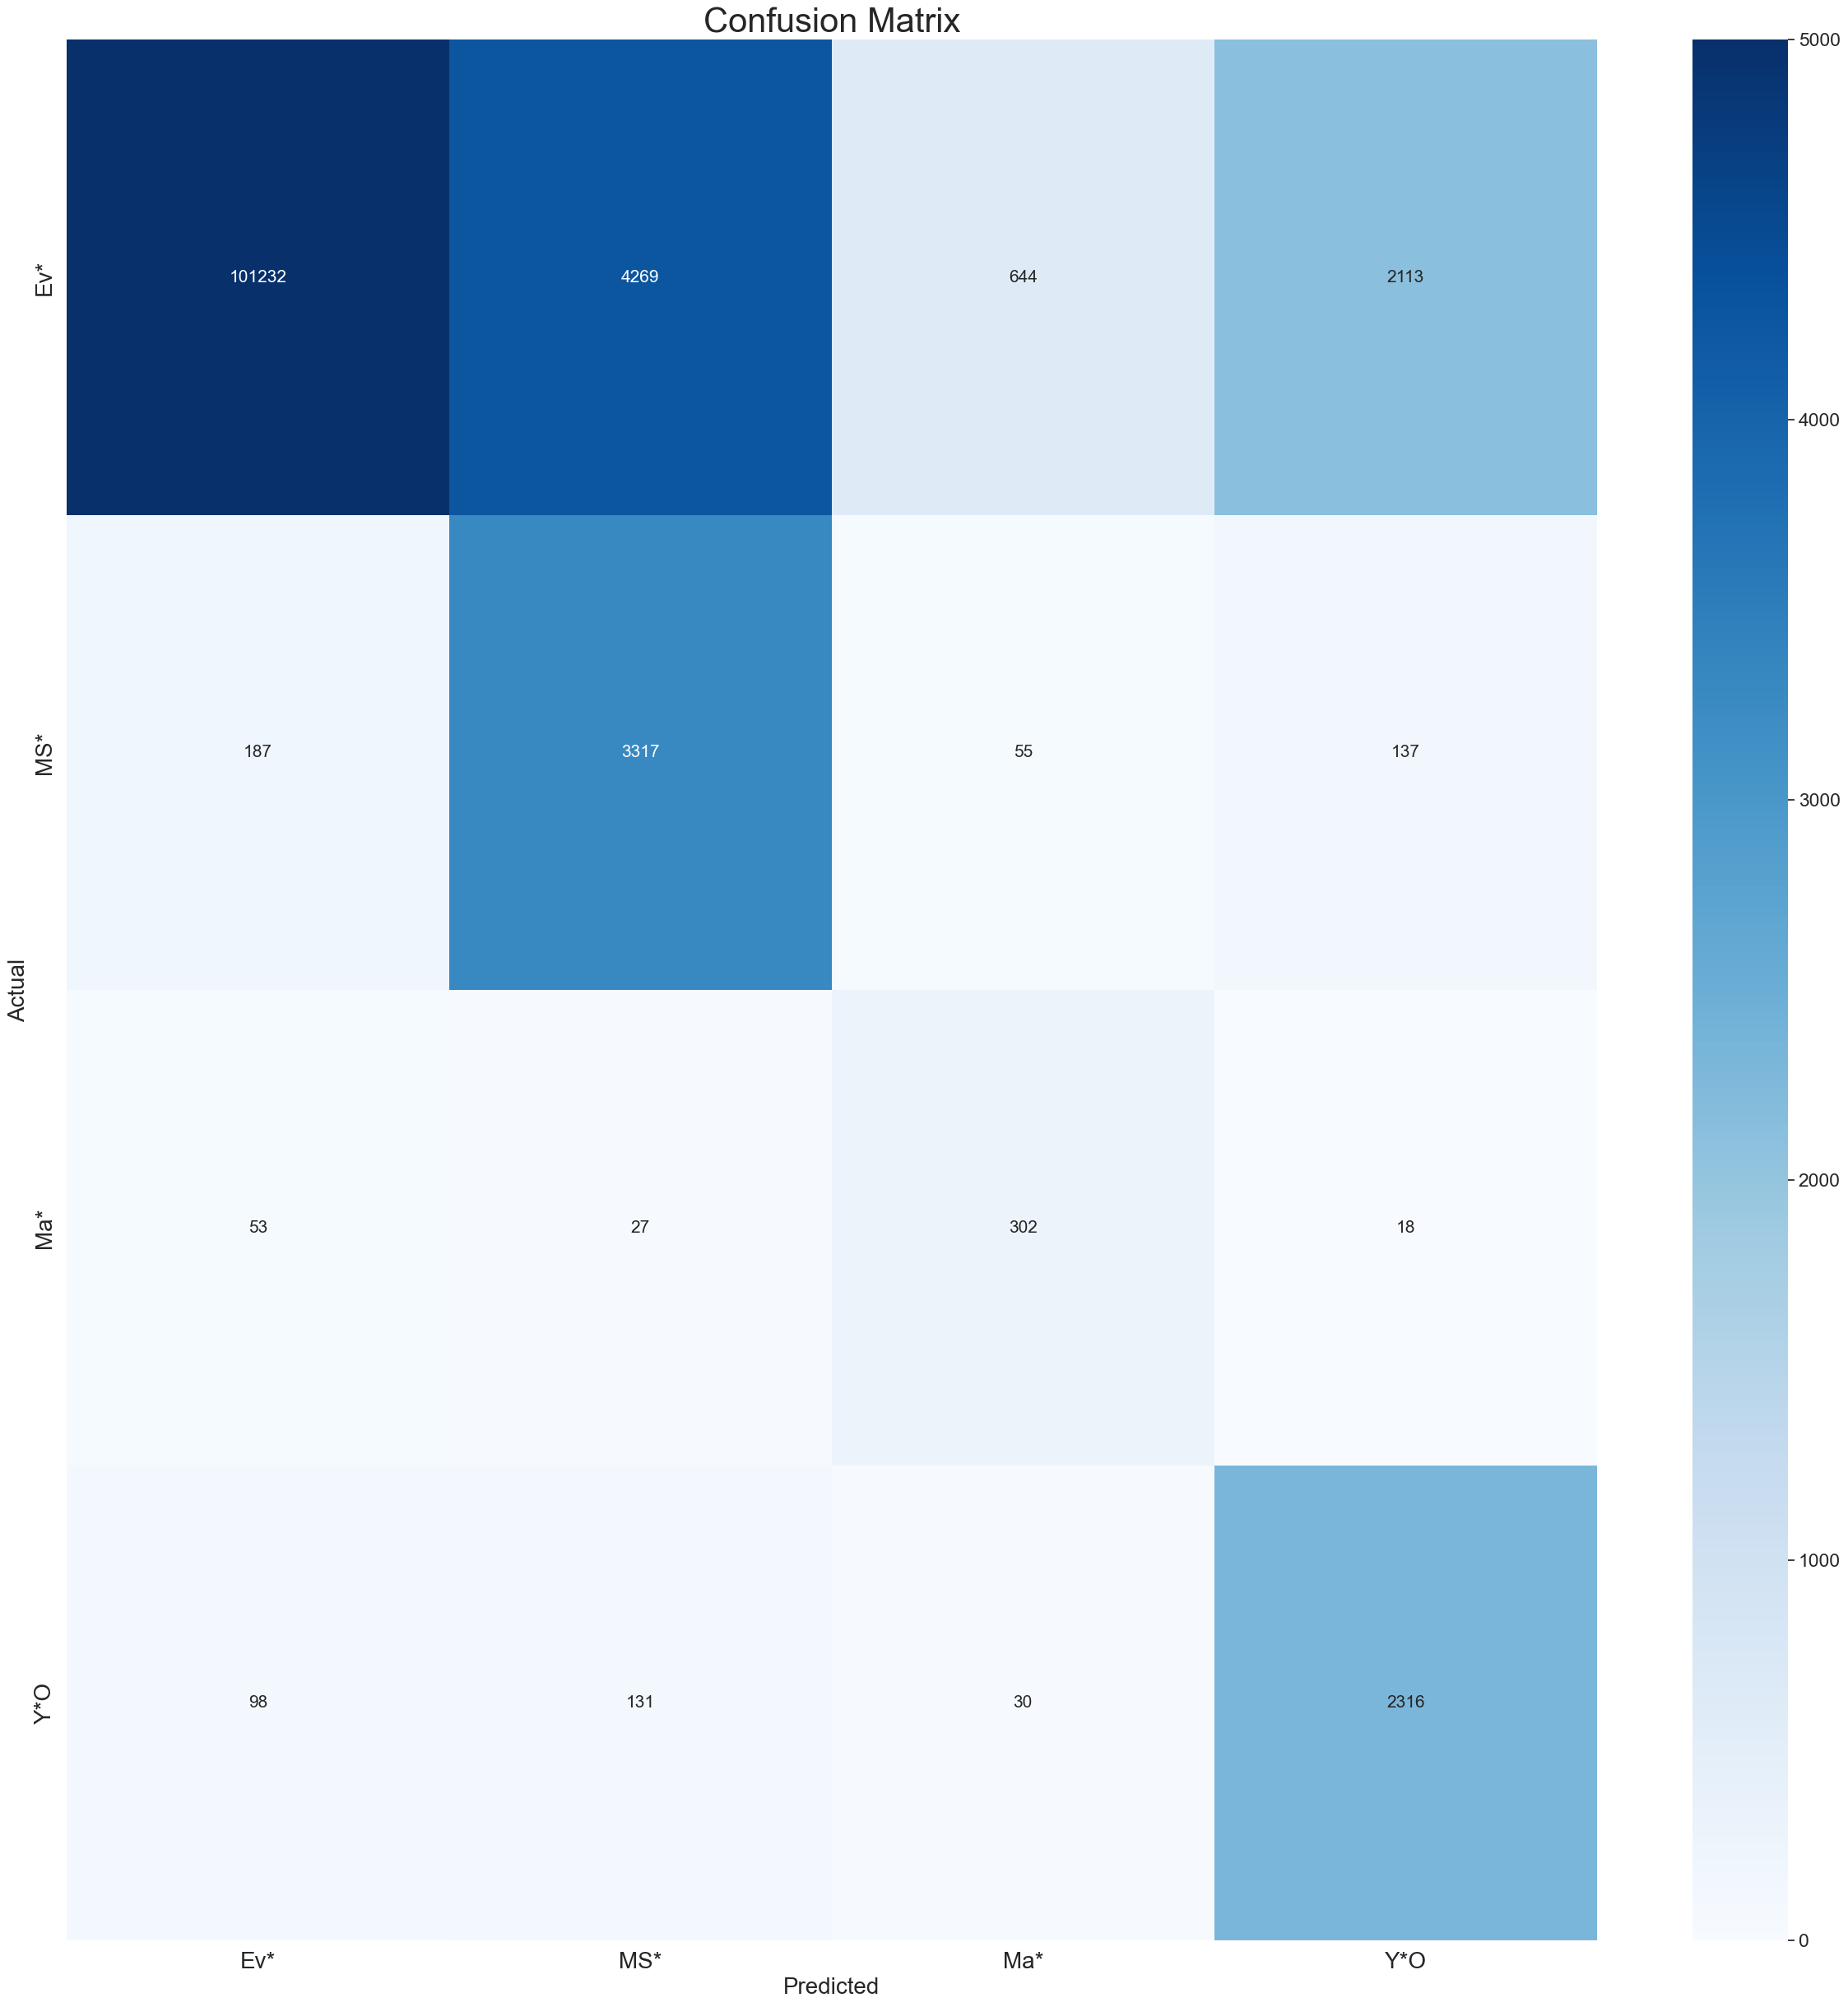

In [6]:
# Load the saved model
#model = NeuralNetwork(input_size, output_size).to(device)
#model.load_state_dict(torch.load('star_classifier_Exp2.pth'))
model.to(device)

# Make predictions on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        # _, labels = torch.max(y_batch.data, 1)  # Remove this line
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())  # Just use y_batch directly

# Get the unique labels from your predictions and true labels
unique_labels = np.unique(all_labels)

# Print the classification report for accuracy per category
report = classification_report(all_labels, all_preds, labels=unique_labels, target_names=encoder.classes_[unique_labels])
print("Classification Report:\n", report)


# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(30, 30))
sns.set(font_scale=1.5)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', vmin=0, vmax=5000, 
            xticklabels=encoder.classes_, yticklabels=encoder.classes_, 
            annot_kws={"size": 15})
plt.xlabel('Predicted', fontsize=20)
plt.ylabel('Actual', fontsize=20)
plt.title('Confusion Matrix', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()
